# A hitchhiker's guide to the world
---
### Context
In the paper, "Friendship and mobility : User movement in Location-Based Social Networks", the authors answered one important question : what influence do friends have on movements ?<br>
But what if you don't have friends in the first place and just want to blend in ? Imagine : You just arrived in a new country. You don't know how to behave with the locals and what to expect. How friendly are people ? How often is it socially acceptable to meet ? Where should you meet ? Where and when should you go on holidays ? <br>
In this Notebook, we will attempt to answer some of these questions for multiple countries.

---
### The data
“Global-scale Check-in Dataset with User Social Networks” from two research projects at this address (project 5 by Dingqi Yang): ( https://sites.google.com/site/yangdingqi/home/foursquare-dataset#h.p_7rmPjnwFGIx9). The dataset is coming from Foursquare and it contains the information of 22,809,624 checkins by 114,324 users, 607,333 friendship links and 3,820,891 POIs. It contains a set of worldwide check-ins with country flags taken over about two years and two snapshots of the corresponding user social network before (in Mar. 2012) and after (in May 2014) the check-in data collection period. <br>
In order to work with this dataset, we broke it down in smaller datasets, based on countries. In order to learn more on how we broke our dataset down, please consult the scripts "createSubDataset.ipynb" and "preprocess.ipynb".

---
### Structure of this notebook
In every subpart of this notebook, we will try to answer a different question. You will find the index of all questions here : 

- Step 1 : How many friends do natives have ?
    - Subpart 1 : Finding the nationality of users.
    - Subpart 2 : Computing number of friends.
- Step 2 : Behaving like Natives, to what POIs do users go and in what context ?
- Step 3 : We want to go deeper with our previous analysis and compute a basic mobility model.
---
### Note :
In the following notebook, all the calculations are done on one database, because they all have the same structure. When it come to the data story, we will extract information from all datasets.

In [116]:
import pandas as pd
from zipfile import ZipFile
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.simplefilter(action='ignore')

### Step 1 : How many friends do native users have ?

We want to measure how sociable natives are. In order to do so, we look at how many friends they have.

### Subpart 1 : Finding nationalities
---

We open a dataset (example : the check-ins that took place in the US in 2013). However, we don't know if all the people of this dataset are American or foreigner on vacation. Since we want to study the behaviour of the locals, we need a criterion to distinguish natives from foreigners.
- Idea 1 : We choose that a person is considered a native if he checks in more than five times in the country.
- Idea 2 : A person is considered a foreigner if he never checks in a home.

#### Idea 1

In [2]:
data_file = ZipFile('../data.zip')
df_US = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'))

In [3]:
df_US

,zone_id,person_id,time_checkin,year,Lat,lon,building,country
0,3fd66200f964a52000e71ee3,319827,2013-01-13 00:49:25+00:00,2013,40.733596,-74.003139,Jazz Club,US
1,3fd66200f964a52000e71ee3,496140,2013-01-13 01:12:49+00:00,2013,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e71ee3,288077,2013-02-16 02:29:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
3,3fd66200f964a52000e71ee3,191931,2013-02-17 03:50:53+00:00,2013,40.733596,-74.003139,Jazz Club,US
4,3fd66200f964a52000e71ee3,1402791,2013-02-19 03:48:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
...,...,...,...,...,...,...,...,...
1187592,52b6450811d248b7b0610626,1243714,2013-12-22 01:50:10+00:00,2013,33.873249,-118.387099,Home (private),US
1187593,52b65856498e252aade808b5,120150,2013-12-22 03:12:02+00:00,2013,39.281602,-76.593760,Lounge,US
1187594,52b66bde498e5705ff1ef091,212157,2013-12-22 04:48:06+00:00,2013,33.546776,-117.131694,Other Great Outdoors,US
1187595,52b67f4e498e403b8cccbe27,133864,2013-12-22 06:24:48+00:00,2013,42.331624,-83.066572,Dive Bar,US


In [4]:
US_participants = df_US.groupby(by = "person_id").agg("count")
US_natives =  US_participants[US_participants["zone_id"] >= 5]
US_foreign = US_participants[US_participants["zone_id"] < 5]
US_natives["zone_id"]

person_id
19         146
54          40
58          73
120         56
178         91
          ... 
2169607      5
2169991     27
2174127     92
2174989      6
2181131    116
Name: zone_id, Length: 16987, dtype: int64

In [5]:
df_US_foreign = df_US[df_US["person_id"].isin(US_foreign.index.tolist())]
df_US_natives = df_US[df_US["person_id"].isin(US_natives.index.tolist())]
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(US_natives.shape[0]))
print('Out of all our users, {}% have low checkins.'.format(round((1-US_natives.shape[0]/US_participants.shape[0])*100)))

Our initial dataset had 20495 users.
Out of them, 16987 are considered natives.
Out of all our users, 17% have low checkins.


Getting rid of users can seem a bit dangerous because we lose data. However, since we get rid of users with a low number of Checkins, there isn't too much loss. Furthermore, we can associate low checkin users to visitors and get an approximation of the number of visitors.

#### Most popular places among natives

<BarContainer object of 20 artists>

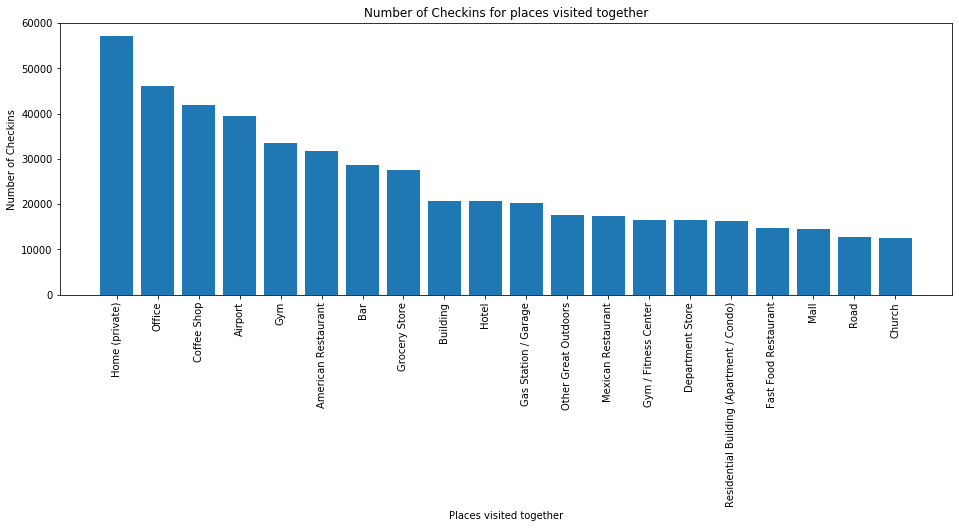

In [6]:
popular_places = df_US_natives.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places.head(20).index]
my_values = [element[0] for element in popular_places.head(20).values]
plt.bar(my_index, my_values)

**Interpretation**: Unsurprinsingly, most people check-in at their home and on the workplace (places where they go the most). The fact that hole locations are the most popular chckin place justifies our approach for assigning house locations to users. We also notice that they check-in a lot in Coffee Shops (which we can interpret as "they check-in during break time"). For Airports, we can interpret it as traveling for work (or going from one coast to another) or leisure. When it comes to food, the two most popular restaurants to go to are American and Mexican restaurants (Fast-food being the third one). This may come from the fact that these three types of restaurants are the most represented in the country. <br>
We notice that if we increase the threshold from "We choose that a person is considered a native if he checks in more than five times in the country" to "We choose that a person is considered a native if he checks in more than ten times in the country", our most popular places stay the same for natives and foreigners.

<BarContainer object of 20 artists>

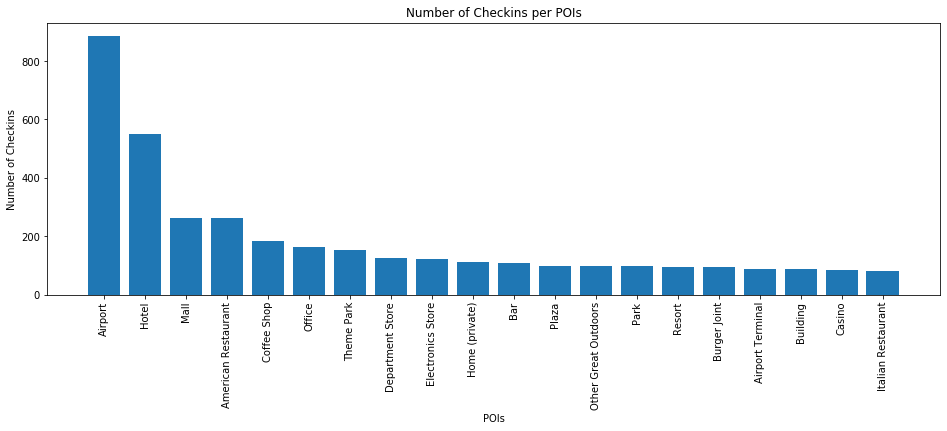

In [7]:
popular_places_foreign = df_US_foreign.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins per POIs')
plt.ylabel('Number of Checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places_foreign.head(20).index]
my_values = [element[0] for element in popular_places_foreign.head(20).values]
plt.bar(my_index, my_values)

In [8]:
df_US_foreign[df_US_foreign["building"] == "Home (private)"]

,zone_id,person_id,time_checkin,year,Lat,lon,building,country
365691,4b47caf8f964a520f13e26e3,107355,2013-01-03 19:59:33+00:00,2013,41.531396,-93.555966,Home (private),US
365693,4b47caf8f964a520f13e26e3,107355,2013-01-08 00:09:35+00:00,2013,41.531396,-93.555966,Home (private),US
587581,4bc62588f360ef3b333adb2d,500843,2013-11-29 19:49:08+00:00,2013,28.367592,-81.510266,Home (private),US
658612,4c03d46e9a7920a1fc5cd079,156601,2013-01-27 06:16:51+00:00,2013,40.833966,-81.806039,Home (private),US
693549,4c3035fd7cc0c9b6151bed9a,252081,2013-01-28 06:22:10+00:00,2013,33.433488,-86.686288,Home (private),US
...,...,...,...,...,...,...,...,...
1184766,5236144b11d27df7715dfd83,217728,2013-09-15 20:11:19+00:00,2013,38.630324,-121.325569,Home (private),US
1184956,5239b34611d2ab4763dec28a,1267538,2013-09-18 14:07:49+00:00,2013,40.726044,-73.883070,Home (private),US
1185037,523b4634498ea178a5a57a94,278252,2013-09-19 18:46:07+00:00,2013,32.349171,-97.389477,Home (private),US
1187465,52a636eb11d21b372b71cfc1,1161008,2013-12-10 21:30:06+00:00,2013,39.474366,-84.475014,Home (private),US


**Interpretation**: We look back at the people we classified as foreigners and want to see where they checked-in in order to verify our assumptions. We see that they checked mainly in Hotels, Airports, Malls, Restaurants and Coffee Shops which are destinations that any tourist would go to. However, since we have much less data then last part, we can suspect that these popular places may know high variance. <br>
We however notice that a lot of users who are classified as foreigners check-in at a home. While this can be considered as them checking in a friend or them just going to a zone_id with many houses, we want to investigate. We try a second model, where we classify as foreigner people who never check-in in a Home.

#### Idea 2

In [9]:
list_of_people_with_homes = df_US[df_US["building"] == "Home (private)"].person_id.unique().tolist()
df_US_natives_2 = df_US[df_US["person_id"].isin(list_of_people_with_homes)]

In [10]:
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(len(df_US_natives_2.person_id.unique().tolist())))

Our initial dataset had 20495 users.
Out of them, 5364 are considered natives.


We notice that when we keep only users with a Home, the number of users falls drastically. We therefore think that going to a home is not an interesting criterion for determining if a user is a native.

### Subpart 2 : Number of friends
---

Now that we have our native users, we want to see how many friends they have. This can serve as an index of how social are the people of the country. In order to have more precise, we compute a 90% confidence interval.

In [11]:
friend_file = ZipFile('../dataset_WWW2019.zip')
df_friend = pd.read_csv(friend_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
nb_friends = []
for i in range(20):
    sample_abb = US_foreign.sample(frac = 0.8, random_state = i)
    df_friend = df_friend[df_friend.friend.isin(sample_abb.index.tolist())]
    nb_friends.append(df_friend.shape[0]/len(df_friend.friend.unique()))
nb_friends.sort()

In [12]:
print("Natives have on average {} friends, our 90% confidence interval is[ {}, {}]".format(np.average(nb_friends), nb_friends[1], nb_friends[-2]))

Natives have on average 6.263280768106974 friends, our 90% confidence interval is[ 4.91578947368421, 7.822822822822823]


We have an average, however, we don't even know if it is relevant or not. In order to do so, we look at our quartiles.

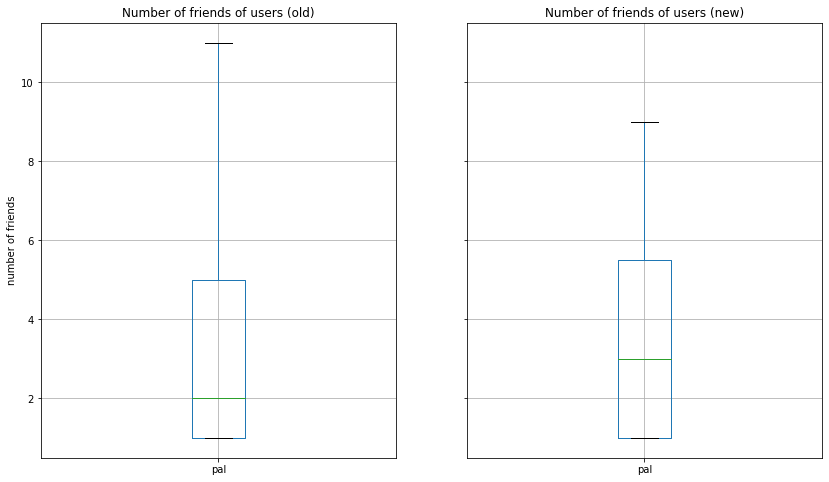

In [13]:
df_friend_old = pd.read_csv(friend_file.open('dataset_WWW2019/dataset_WWW_friendship_old.txt'), header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(1,2, figsize = (14, 8), sharey = True)
ax[0].set_title("Number of friends of users (old)")
ax[1].set_title("Number of friends of users (new)")
ax[0].set_ylabel("number of friends")
df_friend_old.groupby("friend").count().boxplot(ax = ax[0], column = ['pal'],showfliers=False)
df_friend.groupby("friend").count().boxplot(ax = ax[1], column = ['pal'],showfliers=False)

The results indicate us that most users don't have many friends on Foursquare. There are a few "super users" that have a lot of friends and they falsify our average values. If we want to find meaningful results, we should work on the quartiles. This structure of friendships is topical of social networks.<br>
We notice that the number seems to have grown over time, but not by a lot.

### Step 2 : Behaving like natives

Now that we have an idea of how sociable natives are, we need to identify how they behave. In order to do so, we must identify the places they go to, at what frequency, and what combinations of places they go on the same day.<br>
The graph below gives us some information on activities that natives do, but we don't know much about the context. Imagine for example that everybody goes shopping on the week-end : what a major "faux-pas" it would be to go on weekdays after work ! What if you want to hang out ? What combination of activities should you choose ? So many questions...

In [14]:
# We recall the results we had last time. We need to identify if this behavior is representative of the whole
# population or if this is particular to a subset of individuals.
df_US_natives.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False).head(10)

,zone_id,person_id,time_checkin,year,Lat,lon,country
building,,,,,,,
Home (private),57199,57199,57199,57199,57199,57199,57199
Office,46155,46155,46155,46155,46155,46155,46155
Coffee Shop,41905,41905,41905,41905,41905,41905,41905
Airport,39503,39503,39503,39503,39503,39503,39503
Gym,33533,33533,33533,33533,33533,33533,33533
American Restaurant,31631,31631,31631,31631,31631,31631,31631
Bar,28661,28661,28661,28661,28661,28661,28661
Grocery Store,27498,27498,27498,27498,27498,27498,27498
Building,20612,20612,20612,20612,20612,20612,20612


In [15]:
# We start by creating a column indicating the day of the checkin

df_US_natives["day_of_check_in"] = df_US_natives["time_checkin"].apply(lambda x : x[:10])

# We start by looking at how many checkins each user does daily. From this, we extract the list of users and 
# that checked-in more than once per day and the dataframe of their checkins.
multi_day_dataset = df_US_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
list_of_multi_day = multi_day_dataset[multi_day_dataset["zone_id"]>1].index.to_list()
dataframe_multi_day = df_US_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# A first interesting observation is that most checkins come from people that checked more than once per day.
dataframe_multi_day.shape[0]/df_US_natives.shape[0]

0.5500185602343166

In [17]:
dataframe_multi_day

time_checkin        building
person_id day_of_check_in                                           
347405    2013-01-12       2013-01-12 05:49:08+00:00      University
          2013-01-12       2013-01-12 07:40:27+00:00      University
          2013-01-12       2013-01-12 08:17:48+00:00      University
          2013-01-12       2013-01-12 09:25:48+00:00  Student Center
          2013-01-12       2013-01-12 09:26:03+00:00  Student Center
...                                              ...             ...
413005    2013-03-24       2013-03-24 16:32:05+00:00           Diner
98454     2013-01-18       2013-01-18 01:40:15+00:00             Bar
          2013-01-18       2013-01-18 14:34:21+00:00        Hospital
102862    2013-02-19       2013-02-19 13:50:52+00:00          School
          2013-02-19       2013-02-19 20:54:08+00:00          School

[648990 rows x 2 columns]

In [18]:
# There are some people who check multiple times a day to the same place. We interpret this as them checking-in 
# On their workplace or at their home. This does not interest us. As a result, we eliminate users who check-in
# only at the same place.

count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count").reset_index()
inter = count_nb_checkin_per_day.groupby(by = ["person_id", "day_of_check_in"]).agg("count")
inter_list = inter[inter["building"]>1].index.to_list()
people_who_checked_at_multiple_places = count_nb_checkin_per_day.set_index(["person_id", "day_of_check_in"]).loc[inter_list].reset_index()
merged_db = people_who_checked_at_multiple_places.merge(people_who_checked_at_multiple_places, on = ["person_id", "day_of_check_in"])
merged_db = merged_db[merged_db["building_x"] != merged_db["building_y"]].drop(columns = ["time_checkin_x"])

In [19]:
# We now put on a label indicating the two activities that are done at the same time. The label is : 
# (activity_1, activity_2). Since (activity_1, activity_2) = (activity_2, activity_1), we have each row repeated 
# twice. We will take care of this later.
inter = pd.DataFrame()
inter["first_building"] = merged_db["building_x"]
inter["second_building"] = merged_db["building_y"]
inter_list = inter.values.tolist()
merged_db["label"] = [tuple(sorted(list(val))) for val in inter_list]

In [20]:
merged_db

,person_id,day_of_check_in,building_x,building_y,time_checkin_y,label
1,19,2013-01-05,Airport,Tech Startup,1,"(Airport, Tech Startup)"
2,19,2013-01-05,Tech Startup,Airport,1,"(Airport, Tech Startup)"
5,19,2013-01-09,Coffee Shop,University,1,"(Coffee Shop, University)"
6,19,2013-01-09,University,Coffee Shop,1,"(Coffee Shop, University)"
9,19,2013-01-11,Bar,Italian Restaurant,1,"(Bar, Italian Restaurant)"
...,...,...,...,...,...,...
1876122,2181131,2013-04-24,Residential Building (Apartment / Condo),Home (private),1,"(Home (private), Residential Building (Apartme..."
1876125,2181131,2013-04-25,Building,Residential Building (Apartment / Condo),1,"(Building, Residential Building (Apartment / C..."
1876126,2181131,2013-04-25,Residential Building (Apartment / Condo),Building,1,"(Building, Residential Building (Apartment / C..."
1876129,2181131,2013-04-29,Building,Home (private),1,"(Building, Home (private))"


In [21]:
# Now, we want to evaluate the occurence of each label, we also divide our values by 2 in order to compensate
# the fact that (activity_1, activity_2) = (activity_2, activity_1)
db_ordered_by_labels = merged_db.groupby("label").agg("count").sort_values(by = "person_id", ascending = False).drop(columns = ["day_of_check_in","building_x", "building_y", "time_checkin_y" ])
db_ordered_by_labels["person_id"] = db_ordered_by_labels["person_id"]/2

<BarContainer object of 20 artists>

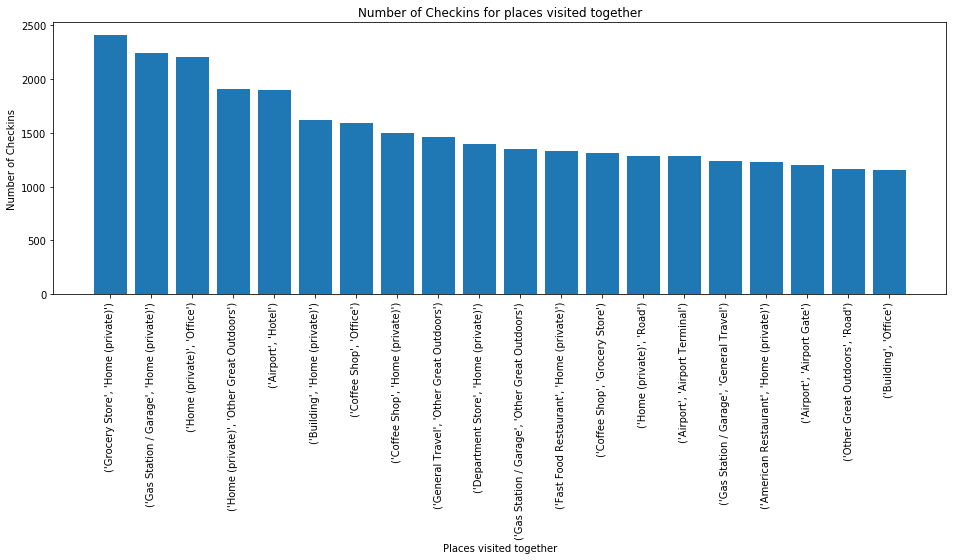

In [22]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in db_ordered_by_labels.head(20).index]
my_values = [element[0] for element in db_ordered_by_labels.head(20).values]
plt.bar(my_index, my_values)

#### Partial conclusion
When we look at the places visited together, we notice that there are a lot of them that are of the form (Place, Home (private)) This comes from the fact that, as we have seen before, Home (private) is the most popular chackin place for our population. We notice that among our popular combinations, we have some that can be explained both intuitively and culturally. For example, the combination (Coffee Shop, Office) has already been mentionned earlier. While the combination, (Airport, Hotel) can be explained intuitively as "when we come from the airport, we have to find a hotel to stay". However, the fact that it is the fifth most popular combination can only be explained as "In the US, since the country is so large, it is much more common to travel by plane".

We now sum up everything that we have done in Step 2 as a python function. In order that our functions translate to other datasets, we check our results with the dataset of japanese logins.

In [127]:
def get_natives(dataframe):
    # We start by removing all users with low checkins, they are classified as foreigner and therefore don't
    # give us a clear view of how to behave like the natives.
    all_participants = dataframe.groupby(by = "person_id").agg("count")
    df_person_natives =  all_participants[all_participants["zone_id"] >= 5]
    df_natives = dataframe[dataframe["person_id"].isin(df_person_natives.index.tolist())]
    return(df_natives)

def get_combination_natives(df_natives, poi_interest = False):
    # We then create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We now extract the dataframe of all the users that made multiple checkins per day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_of_multi_day = inter[inter["zone_id"]>1].index.to_list()
    dataframe_multi_day = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])
    
    # The next step is surpressing all the check-ins from people who check-in from the same place in order to focus on
    # only on people who visit multiple places on the same day.
    count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count").reset_index()
    inter = count_nb_checkin_per_day.groupby(by = ["person_id", "day_of_check_in"]).agg("count")
    inter_list = inter[inter["building"]>1].index.to_list()
    people_who_checked_at_multiple_places = count_nb_checkin_per_day.set_index(["person_id", "day_of_check_in"]).loc[inter_list].reset_index()
    merged_db = people_who_checked_at_multiple_places.merge(people_who_checked_at_multiple_places, on = ["person_id", "day_of_check_in"])
    merged_db = merged_db[merged_db["building_x"] != merged_db["building_y"]].drop(columns = ["time_checkin_x"])
    
    # We now put on a label indicating the two activities that are done at the same time. The label is : 
    # (activity_1, activity_2). Since (activity_1, activity_2) = (activity_2, activity_1), we have each row repeated 
    # twice. We will take care of this later.
    inter = pd.DataFrame()
    inter["first_building"] = merged_db["building_x"]
    inter["second_building"] = merged_db["building_y"]
    inter_list = inter.values.tolist()
    merged_db["label"] = [tuple(sorted(list(val))) for val in inter_list]
    
    # If we give a value for "poi_interest", we return not only the dataframe of combinations, but also the number
    # of times users check-ed at the place "poi_interest"
    if poi_interest:
        return(merged_db, sum(people_who_checked_at_multiple_places.set_index("building").loc[poi_interest]["time_checkin"]))
    
    return(merged_db)

In [24]:
df_JP = pd.read_csv(data_file.open('data/6_JP_2013_merge_data.csv'))
natives_JP = get_natives(df_JP)
combination_df_JP = get_combination_natives(natives_JP)
db_ordered_by_labels = combination_df_JP.groupby("label").agg("count").sort_values(by = "person_id", ascending = False).drop(columns = ["day_of_check_in","building_x", "building_y", "time_checkin_y" ])
db_ordered_by_labels["person_id"] = db_ordered_by_labels["person_id"]/2

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<BarContainer object of 20 artists>

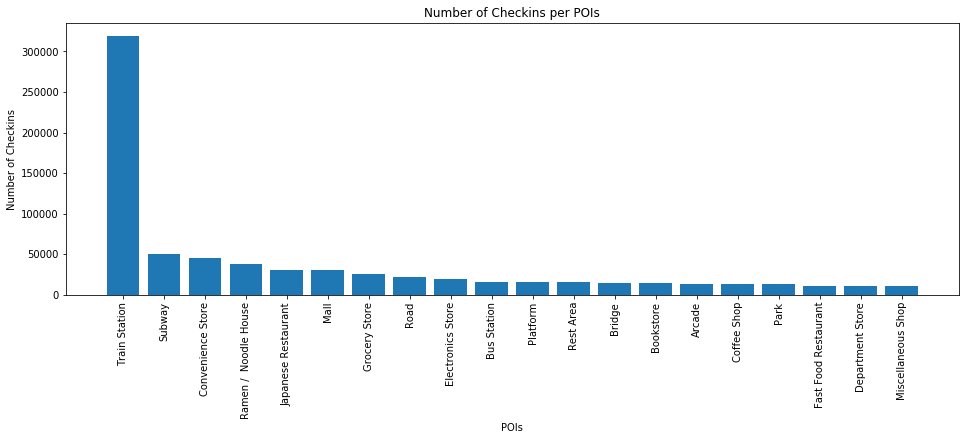

In [25]:
popular_places = natives_JP.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins per POIs')
plt.ylabel('Number of Checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places.head(20).index]
my_values = [element[0] for element in popular_places.head(20).values]
plt.bar(my_index, my_values)

We notice that an overwhelming amount of checkins are made in train stations. This is due to the fact that the Shinkansen (bullet train) is very popular (https://en.wikipedia.org/wiki/Transport_in_Japan) and that owning a car is not something as common as in the US. We notice that the most popular places to eat are "Ramen/noodle house" and "Japanese Retaurant" which makes sense intuitively. We notice also the appearance of typical japanese places like the arcade (who died too soon in all countries except Japan. RIP sweet arcades, we won't forget you).<br>
A problem that appears with our data is that when we compute house locations, we look at the place with the biggest number of check-ins. In the case of Japan, that might be the position of the nearest train station from home and not of the real home position.

<BarContainer object of 20 artists>

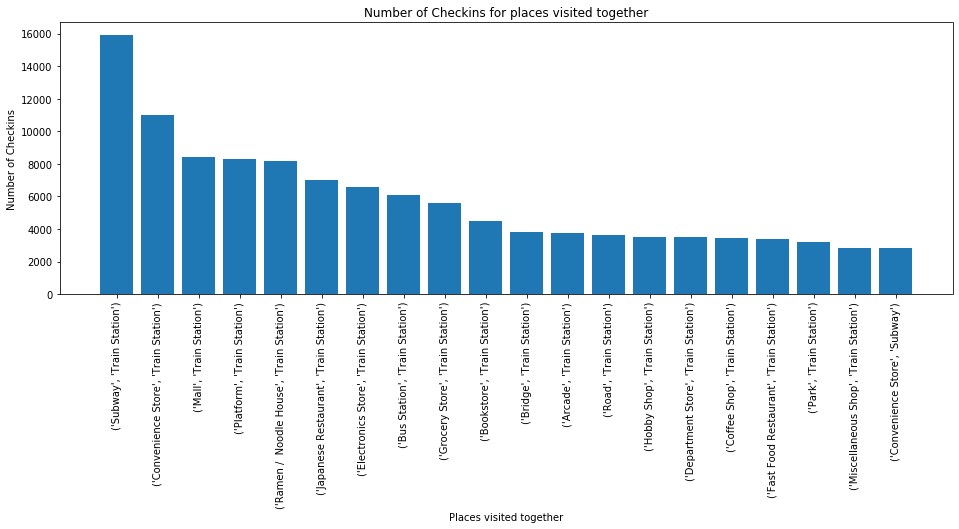

In [26]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in db_ordered_by_labels.head(20).index]
my_values = [element[0] for element in db_ordered_by_labels.head(20).values]
plt.bar(my_index, my_values)

Due to the over-representation of "Train Station" in our checkins, it becomes difficult to infer meaningful information from the combinations of checkins. What we can guess is that Japanese people use the public transport a lot, both for work and leisure purposes.

### Step 3 : Computing probabilities

### Substep 1 : The first Checkin

During the last two parts, we observed what users did in order to understand their behaviours. We noticed and studied cultural specificities. We now want to compute predictive probabilities. We will try to answer the following questions :<br>
- What is the probability that a user checks-in multiple times a day?
- If a user checks-in multiple times, what is the probability that he checks-in from the same POI (given the POI)?
- If a user checks-in multiple times, what is the probability that he checks-in from different POIs, and which POIs is he most likely to check-in from (given the first place)? In our model, we will only study the case where we study the previous check-in. (More complicated models can try to give predictions out of all the previous check-ins).

We think that it is interesting to separate our checkins as "first checkin of the day" and "not first checkin of the day" because 
1) People have habits. Some check their phone every morning, others on their way to work... It is usually the same POI. When people checkin only once a day, we can still identify a POI from where they check-in most of the time.
2) If a person checks-in more than once a day, we can use our dataframe of couples of places to identify where the next check-in should be, based on the previous POI.

In [27]:
# First case : first check-in of the day. We start by computing the distributions for the first check-in of the day.
# In order to do so, we isolate the first check-in for every user and every day.

def get_distrib_first_checkin(df_natives):
    # We then create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We now extract the dataframe of all the first_checkins for a user.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).first().reset_index()
    popular_places_first_checkin = inter.groupby(["building"]).agg("count").sort_values(by = "zone_id", ascending = False)
    popular_places_first_checkin["my_stat"] = popular_places_first_checkin["person_id"] / sum(popular_places_first_checkin["person_id"]) * 100
    popular_places_first_checkin = popular_places_first_checkin.reset_index()
    return(popular_places_first_checkin[["building", "my_stat"]])

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 20 artists>

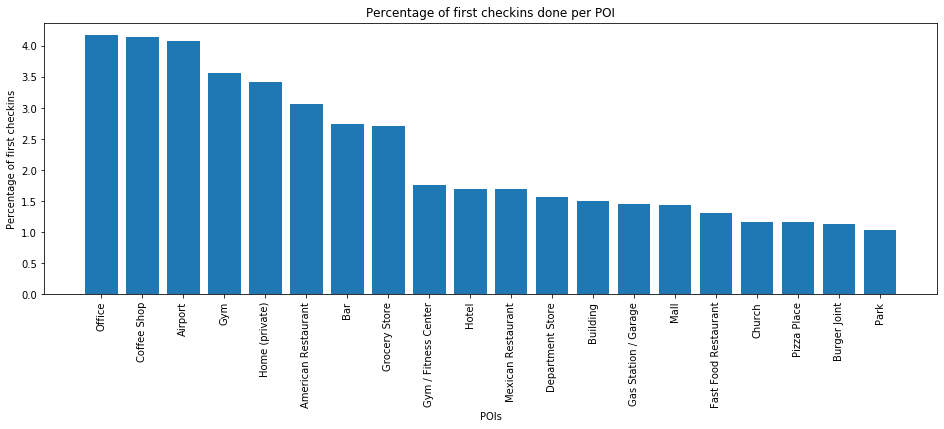

In [28]:
df_US = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'))
US_natives = get_natives(df_US)
US_first_checkin = get_distrib_first_checkin(US_natives)
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Percentage of first checkins done per POI')
plt.ylabel('Percentage of first checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [element for element in US_first_checkin.head(20).building]
my_values = [element for element in US_first_checkin.head(20).my_stat]
plt.bar(my_index, my_values)

#### Interpretation :
While "Home (private)" is the place with the most checkins in our US dataframe, we notice that users from the US usually don't check-in directly after waking up from their home. If users check-in mostly from their home, they do it after work.

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 20 artists>

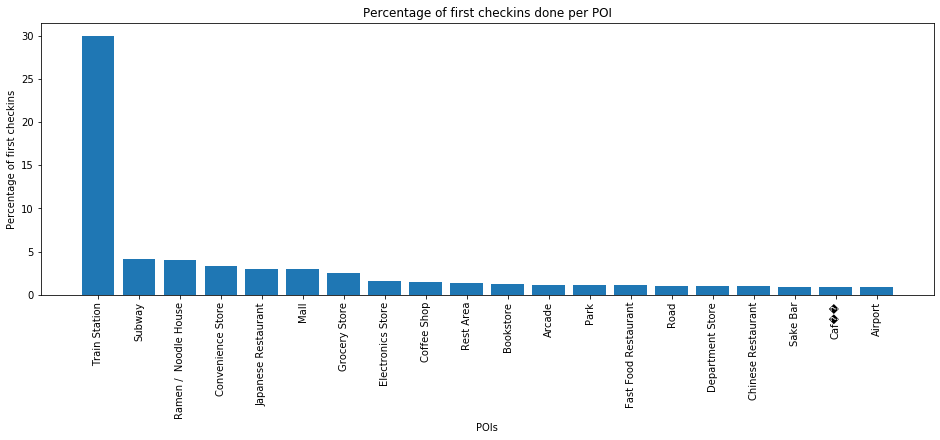

In [29]:
df_JP = pd.read_csv(data_file.open('data/6_JP_2013_merge_data.csv'))
natives_JP = get_natives(df_JP)
JP_first_checkin = get_distrib_first_checkin(natives_JP)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Percentage of first checkins done per POI')
plt.ylabel('Percentage of first checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [element for element in JP_first_checkin.head(20).building]
my_values = [element for element in JP_first_checkin.head(20).my_stat]
plt.bar(my_index, my_values)

#### Interpretation :
After what we have seen on Japan, we expected results like these : threre is a very high probability that users check-in while at the train station. other results are crushed in comparaison.

### Substep 2 : The second checkin and above

We now want to study all checkins that took place after the first check-in. In order to do so, we create a function that, given the POI received at the first checkin, gives the probability for our second check-in.

In [90]:
# We have already a function that, given a dataframe, retrieves the combinations of (POI 1, POI 2). We now create a
# function that returns the number of times where users have checked-in at the same place.

def get_check_same_place(df_natives):
    # We first create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We start by retrieving the users that checked more than once on the same day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_of_multi_day = inter[inter["zone_id"]>1].index.to_list()
    dataframe_multi_day = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])
    
    # There are two possible cases : either the user stays at the same POI or he moves to the different POI
    # In order to find what we want, we extract the datasets of all users that checked more than once at the same
    # place on the same day.
    count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count")
    dataset_check_same_place = count_nb_checkin_per_day[count_nb_checkin_per_day["time_checkin"]>1].reset_index().drop(columns = {"person_id", "day_of_check_in"})
    #### We want to not take into account the first checkin for all the places where we check-in multiple times
    # As a result, we substract 1 from our counts to remove the first checkin
    dataset_check_same_place["time_checkin"] = dataset_check_same_place["time_checkin"] - 1
    probability_dataset = dataset_check_same_place.groupby(by = ["building"]).agg("count")
    
    return(probability_dataset.sort_values(by = "time_checkin",ascending = False))

In [91]:
get_check_same_place(US_natives)

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time_checkin
building,
Airport,5469
Home (private),5143
Road,2049
Office,1708
Other Great Outdoors,1577
...,...
Paella Restaurant,1
College & University,1
Storage Facility,1


In [149]:
# The following function returns for a given dataframe, and a given POI the probability that :
# - The user doesn't check-in another time in the day
# - The user checks-in another time in the day from the same place
# - The user checks-in another time in the day from another place

# If we put info to True, the function will return the probability that we check to each POI given that we check-in
# another time in the day from another place.

def get_probability(df_natives,poi_first_checkin, info = False):
    # We first create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We start by retrieving the number of checkins for users that checked only once per day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_single_day = inter[inter["zone_id"]==1].index.to_list()
    dataframe_single = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_single_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"]).reset_index()
    dataframe_single = dataframe_single.groupby(by = "building").agg("count").sort_values(by = "time_checkin",ascending = False)
    number_no_other_checkin = dataframe_single.loc[poi_first_checkin]["time_checkin"]
    
    # We then retrieve the number of checkins for users that checked-in more than once at the same place on the
    # same day.
    dataframe_twice_same = get_check_same_place(df_natives)
    number_check_same_place = dataframe_twice_same.loc[poi_first_checkin]["time_checkin"]
    
    # We finally extract the number of combinations featuring the POI "poi_first_checkin"
    dataframe_combination, number_different_place = get_combination_natives(df_natives, poi_first_checkin)
    
    # We compute our probabilities
    probability_no_other_checkin = number_no_other_checkin/(number_no_other_checkin+number_check_same_place+number_different_place)
    probability_check_same_place = number_check_same_place/(number_no_other_checkin+number_check_same_place+number_different_place)
    probability_different_place = number_different_place/(number_no_other_checkin+number_check_same_place+number_different_place)
    
    if info:
        # If we put info to True, the function will return the probability that we check to each POI given 
        # that we check-in another time in the day from another place.
        dataframe_combination["is_in_label"] = dataframe_combination["label"].apply(lambda x : True if poi_first_checkin in x else False )
        dataframe_combination = dataframe_combination[dataframe_combination["is_in_label"]].drop(columns = {"day_of_check_in","building_x","building_y","time_checkin_y"})
        dataframe_combination = dataframe_combination.groupby("label").agg("count").reset_index()
        dataframe_combination["person_id"] = dataframe_combination["person_id"]/sum(dataframe_combination["person_id"])
        dataframe_combination = dataframe_combination.drop(columns = {"is_in_label"}).set_index("label").sort_values(by = "person_id", ascending = False)
        return(probability_no_other_checkin, probability_check_same_place, probability_different_place, dataframe_combination)
    
    return(probability_no_other_checkin, probability_check_same_place, probability_different_place)

In [150]:
get_probability(US_natives, "Office", True)

(0.5421903052064632,
 0.036505086774386596,
 0.4213046080191502,
                                   person_id
 label                                      
 (Home (private), Office)           0.061985
 (Coffee Shop, Office)              0.044878
 (Building, Office)                 0.032610
 (Gas Station / Garage, Office)     0.028812
 (Gym, Office)                      0.028502
 ...                                     ...
 (Afghan Restaurant, Office)        0.000028
 (Credit Union, Office)             0.000028
 (Boarding House, Office)           0.000028
 (Conference, Office)               0.000028
 (Gluten-free Restaurant, Office)   0.000028
 
 [403 rows x 1 columns])